***MLP implementation and efficient training techniques***

Goal of this script is to implement a shallow NN that classifies the patients based on their graphomics characteristics.
It also implements regularization techniques that should help avoiding overfitting, on a such small dataset to train on.


In [24]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('PR-graphomics/reduced_graphomics.csv')


X = pd.DataFrame.copy(df)
y = X.pop('Group').values
X = X.values
#X = df.drop(columns=["Group"]).values  # Replace "target_column" with the actual target column name
#y = df["Group"].values  # Replace with actual target column name

# Encode the target column if it's categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert to numerical labels (0 or 1)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Reshape to match output shape

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define dataset and dataloaders
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch [10/100], Loss: 25.0000
Epoch [20/100], Loss: 100.0000
Epoch [30/100], Loss: 50.0000
Epoch [40/100], Loss: 75.0000
Epoch [50/100], Loss: 100.0000
Epoch [60/100], Loss: 50.0000
Epoch [70/100], Loss: 75.0000
Epoch [80/100], Loss: 100.0000
Epoch [90/100], Loss: 75.0000
Epoch [100/100], Loss: 50.0000
Training complete!
Test Accuracy: 51.67%


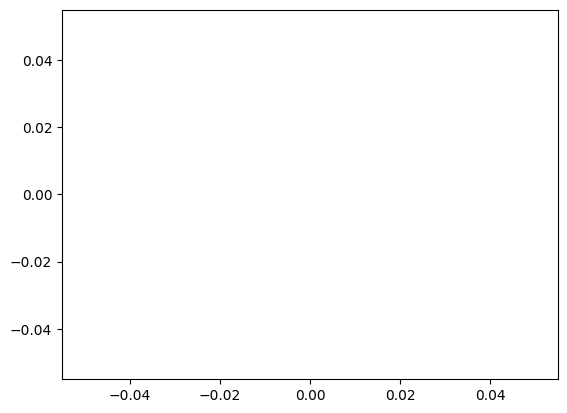

In [70]:


# Define the shallow MLP model
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)  # Output layer for binary classification

    def forward(self, x):
        x = F.relu(self.hidden(x))  # Apply ReLU activation to hidden layer
        x = torch.sigmoid(self.output(x))  # Sigmoid for binary output (probability)
        return x

# Hyperparameters
N = np.shape(X)[1]
input_size = N  # Number of features
hidden_size = 16  # You can adjust the number of neurons in the hidden layer
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model, define loss function and optimizer
model = ShallowMLP(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCELoss()  # Binary cross entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dummy data (replace with your dataset)
#X_train = torch.randn(100, input_size)  # 100 samples, each with N features
#y_train = torch.randint(0, 2, (np.shape(X_train)[0], 1)).float()  # Random binary labels

# Create DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
# Training loop

losses = np.array([])

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Check shapes before calculating loss
        

        loss = criterion(outputs, labels)
        #
        loss.backward()
        optimizer.step()
        np.append(losses, loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        #print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
print("Training complete!")

# Evaluation phase
# Dummy test data (replace with your actual test dataset)
#X_test = torch.randn(30, input_size)  # 30 test samples
#y_test = torch.randint(0, 2, (30, 1)).float()  # Random binary labels

# Evaluate on test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

plt.plot(losses)


Well, the first generation is working someway, even though not amazingly. It's particularly 
Let's try some tricks:
- adding layernorm to avoid neuron deactivation
- adding dropout to diminish overfitting
- adding weight initialization
- adding adaptive learning rate each 20 epochs


In [61]:
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.layer_norm(self.hidden(x)))  # Apply LayerNorm and ReLU
        x = self.dropout(x)  # Apply Dropout to hidden layer
        x = torch.sigmoid(self.output(x))  # Sigmoid for binary output
        return x

# Define the scheduler to decrease learning rate after every 20 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Hyperparameters
N = np.shape(X)[1]
input_size = N  # Number of features
hidden_size = 32  # You can adjust the number of neurons in the hidden layer
learning_rate = 0.0001
num_epochs = 100

# Instantiate the model, define loss function and optimizer
model = ShallowMLP(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCELoss()  # Binary cross entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#weight init
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

# Create DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
# Training loop

losses = np.array([])

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()  # Update the learning rate
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')



model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test)
    predictions = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy * 100:.2f}%")



/home/daniele/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [10/100], Loss: 0.7558
Epoch [20/100], Loss: 0.5963
Epoch [30/100], Loss: 0.5750
Epoch [40/100], Loss: 0.6574
Epoch [50/100], Loss: 0.9968
Epoch [60/100], Loss: 0.5896
Epoch [70/100], Loss: 0.7435
Epoch [80/100], Loss: 0.4816
Epoch [90/100], Loss: 0.5059
Epoch [100/100], Loss: 0.3460
Test Accuracy: 84.44%


In [ ]:

# Load your data
df = pd.read_csv("your_data.csv")  # Replace with your actual file path

# Preprocess data
X = df.drop(columns=["target_column"]).values  # Replace with actual target column name
y = df["target_column"].values  # Replace with actual target column name

# Encode categorical target if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train-validation-test split (60-20-20)
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
train_data, val_data, test_data = random_split(TensorDataset(X, y), [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)  # Small batch size as discussed
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)


Epoch [5/100], Train Loss: 0.6044, Validation Loss: 0.5764
Epoch [10/100], Train Loss: 0.4486, Validation Loss: 0.4525
Epoch [15/100], Train Loss: 0.3884, Validation Loss: 0.4392
Epoch [20/100], Train Loss: 0.4135, Validation Loss: 0.4959
Epoch [25/100], Train Loss: 0.3789, Validation Loss: 0.4501
Epoch [30/100], Train Loss: 0.3638, Validation Loss: 0.4658
Epoch [35/100], Train Loss: 0.3549, Validation Loss: 0.4488
Epoch [40/100], Train Loss: 0.3529, Validation Loss: 0.4659
Epoch [45/100], Train Loss: 0.3330, Validation Loss: 0.4577
Epoch [50/100], Train Loss: 0.3490, Validation Loss: 0.4573
Epoch [55/100], Train Loss: 0.3366, Validation Loss: 0.4511
Epoch [60/100], Train Loss: 0.3245, Validation Loss: 0.4507
Epoch [65/100], Train Loss: 0.3376, Validation Loss: 0.4508
Epoch [70/100], Train Loss: 0.3079, Validation Loss: 0.4488
Epoch [75/100], Train Loss: 0.3411, Validation Loss: 0.4502
Epoch [80/100], Train Loss: 0.3435, Validation Loss: 0.4501
Epoch [85/100], Train Loss: 0.3303, Valid

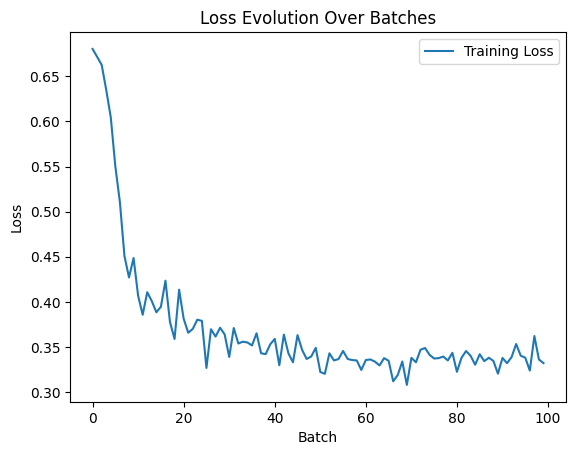

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Load your data
# Load and preprocess data
df = pd.read_csv("PR-graphomics/reduced_graphomics.csv")  # Replace with your file path
X = df.drop(columns=["Group"]).values  # Replace with your target column
y = df["Group"].values  # Replace with actual target column

# Encode categorical target if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train-validation-test split (60-20-20)
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
train_data, val_data, test_data = random_split(TensorDataset(X, y), [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)  # Small batch size as discussed
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

# Model, loss function, and optimizer setup
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.layer_norm(self.hidden(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

input_size = X.shape[1]
hidden_size = 32
learning_rate = 0.001
num_epochs = 100

model = ShallowMLP(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Track losses for analysis
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set to training mode
    batch_losses = []  # Track batch losses for this epoch

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())  # Save the batch loss

    # Average loss for the epoch
    epoch_train_loss = np.mean(batch_losses)
    train_losses.append(epoch_train_loss)

    # Validation loss
    model.eval()  # Set to evaluation mode for validation
    val_batch_losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_batch_losses.append(loss.item())

    epoch_val_loss = np.mean(val_batch_losses)
    val_losses.append(epoch_val_loss)

    scheduler.step()  # Adjust learning rate

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

print("Training complete!")


# Plotting the loss evolution
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Loss Evolution Over Batches")
plt.legend()
plt.show()
# Now `train_losses` and `val_losses` contain the loss evolution per epoch for analysis.


Next Step:

- adding data preprocessing
- searching for best hyperparameters

In [ ]:
#standard scaler principle:

from sklearn.preprocessing import StandardScaler

# Load your data
df = pd.read_csv("PR-graphomics/reduced_graphomics.csv")  # Replace with your file path
X = df.drop(columns=["Group"]).values  # Replace with your target column
y = df["Group"].values  # Replace with actual target column

# Encode categorical target if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import itertools

# Load and preprocess data
df = pd.read_csv("PR-graphomics/reduced_graphomics.csv")  # Replace with your file path
X = df.drop(columns=["Group"]).values  # Replace with your target column
y = df["Group"].values  # Replace with actual target column

# Encode categorical target if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train-validation-test split (60-20-20)
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
train_data, val_data, test_data = random_split(TensorDataset(X, y), [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

# Define the model class
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.layer_norm(self.hidden(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

# Hyperparameter grid
param_grid = {
    'hidden_size': [16, 32, 64],  # Different sizes for hidden layer
    'learning_rate': [0.001, 0.01, 0.1],  # Different learning rates
    'dropout_rate': [0.2, 0.3, 0.5],  # Different dropout rates
}

# Function to train and evaluate a model
def train_and_evaluate_model(hidden_size, learning_rate, dropout_rate):
    model = ShallowMLP(input_size=X.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Train the model
    model.train()
    num_epochs = 100
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        # Calculate average training loss for this epoch
        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)

        # Validation loss
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_batch_losses.append(loss.item())

        epoch_val_loss = np.mean(val_batch_losses)
        val_losses.append(epoch_val_loss)

        scheduler.step()

    # Return the final validation loss for this set of hyperparameters
    return np.mean(val_losses)

# Grid search over hyperparameters
best_val_loss = float('inf')
best_params = None

for params in itertools.product(*param_grid.values()):
    hidden_size, learning_rate, dropout_rate = params
    print(f"Evaluating model with: hidden_size={hidden_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}")
    
    val_loss = train_and_evaluate_model(hidden_size, learning_rate, dropout_rate)

    print(f"Validation loss: {val_loss:.4f}")
    
    # Track the best parameters
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params

print(f"Best parameters: hidden_size={best_params[0]}, learning_rate={best_params[1]}, dropout_rate={best_params[2]}")



Evaluating model with: hidden_size=16, learning_rate=0.001, dropout_rate=0.2
Validation loss: 0.3264
Evaluating model with: hidden_size=16, learning_rate=0.001, dropout_rate=0.3
Validation loss: 0.3221
Evaluating model with: hidden_size=16, learning_rate=0.001, dropout_rate=0.5
Validation loss: 0.3382
Evaluating model with: hidden_size=16, learning_rate=0.01, dropout_rate=0.2
Validation loss: 0.3378
Evaluating model with: hidden_size=16, learning_rate=0.01, dropout_rate=0.3
Validation loss: 0.3364
Evaluating model with: hidden_size=16, learning_rate=0.01, dropout_rate=0.5
Validation loss: 0.3114
Evaluating model with: hidden_size=16, learning_rate=0.1, dropout_rate=0.2
Validation loss: 0.3919
Evaluating model with: hidden_size=16, learning_rate=0.1, dropout_rate=0.3


In [ ]:
num_epochs = 100
# Retrain on full training data with best hyperparameters
best_hidden_size, best_learning_rate, best_dropout_rate = best_params
best_model = ShallowMLP(input_size=X.shape[1], hidden_size=best_hidden_size, dropout_rate=best_dropout_rate)
criterion = nn.BCELoss()
optimizer = optim.AdamW(best_model.parameters(), lr=best_learning_rate)

# Retrain the model on the full training data
train_loader_full = DataLoader(TensorDataset(X, y), batch_size=2, shuffle=True)  # Use full training data

# Train for the same number of epochs
for epoch in range(num_epochs):
    best_model.train()
    batch_losses = []

    for inputs, labels in train_loader_full:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

# Evaluate on the test set
best_model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss on best model: {test_loss:.4f}")

# Plot training and validation losses for the best model (optional)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Evolution Over Epochs")
plt.legend()
plt.show()

In [ ]:
#Version in which results of the grid search are plotted in a heatmap

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Load and preprocess data
df = pd.read_csv("PR-graphomics/reduced_graphomics.csv")  # Replace with your file path
X = df.drop(columns=["Group"]).values  # Replace with your target column
y = df["Group"].values  # Replace with actual target column

# Encode categorical target if necessary
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to torch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train-validation-test split (60-20-20)
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
train_data, val_data, test_data = random_split(TensorDataset(X, y), [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
val_loader = DataLoader(val_data, batch_size=2, shuffle=False)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

# Define the model class
class ShallowMLP(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(ShallowMLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.relu(self.layer_norm(self.hidden(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.output(x))
        return x

# Hyperparameter grid
param_grid = {
    'hidden_size': [16, 32, 64],  # Different sizes for hidden layer
    'learning_rate': [0.001, 0.01, 0.1],  # Different learning rates
    'dropout_rate': [0.2, 0.3, 0.5],  # Different dropout rates
}

# Initialize a list to store the validation losses
results = []

# Function to train and evaluate a model
def train_and_evaluate_model(hidden_size, learning_rate, dropout_rate):
    model = ShallowMLP(input_size=X.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Train the model
    model.train()
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        batch_losses = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(val_loader)

# Grid search over hyperparameters
for params in product(*param_grid.values()):
    hidden_size, learning_rate, dropout_rate = params
    print(f"Evaluating model with: hidden_size={hidden_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}")
    
    val_loss = train_and_evaluate_model(hidden_size, learning_rate, dropout_rate)
    results.append((hidden_size, learning_rate, dropout_rate, val_loss))

# Convert results to a DataFrame for better handling
results_df = pd.DataFrame(results, columns=['Hidden Size', 'Learning Rate', 'Dropout Rate', 'Validation Loss'])

# Pivot the results DataFrame for plotting
pivoted_results = results_df.pivot_table(
    values='Validation Loss', 
    index='Hidden Size', 
    columns=['Learning Rate', 'Dropout Rate']
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivoted_results, annot=True, cmap='viridis', fmt='.4f', cbar_kws={'label': 'Validation Loss'})
plt.title('Hyperparameter Tuning Heatmap')
plt.xlabel('Learning Rate & Dropout Rate')
plt.ylabel('Hidden Size')
plt.show()